In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import numpy as np
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

%store -r WORKDIR

if 'WORKDIR' not in dir():
    WORKDIR = 'C:/Users/Paulo/Desktop/infnet-projeto-final/mit_data_science/'

data_proc_file = WORKDIR + '/Data/Processed/nyctaxi_data_modeling_green.parquet'
save_file = WORKDIR + '/Data/Processed/nyctaxi_data_analysis_green.parquet'

pd.plotting.register_matplotlib_converters()

# Leitura dos Dados 

In [2]:
train = pd.read_parquet(data_proc_file)

print('shape:', train.shape)
print('columns:', train.columns)

shape: (3942, 7)
columns: Index(['dropoff_latitude', 'dropoff_longitude', 'fare_amount',
       'passenger_count', 'pickup_latitude', 'pickup_longitude',
       'pickup_datetime'],
      dtype='object')


## Engineering features

Achamos que os dois fatores que mais importam na tarifa do táxi é a duração da corrida e a distância.
A distância já existe no dataset, porém podemos aplicar outras distâncias como a Euclidiana e Manhattan.

### Duração

A duração da viagem não é dada e não podemos calcular porque a hora de chegada não é dada. Isso faz sentido

porque a intenção do modelo é prever a tarifa **antes** da viagem acontecer

Algo que influencia a duração da viagem é a condição do tráfego. Podemos deduzir usando `pickup_datetime`.

* *hora do dia*: tráfego será menor durante a noite
* *dia da semana*: tráfego será menor nos finais de semana
* *dia do ano*: feriados e férias, por exemplo
* *ano*: pode ser influenciado por mudanças nas regras de transporte ou inflação

In [3]:
train['hour_of_day'] = train['pickup_datetime'].map(lambda date: date.timetuple().tm_hour)

In [4]:
train.head()

,dropoff_latitude,dropoff_longitude,fare_amount,passenger_count,pickup_latitude,pickup_longitude,pickup_datetime,hour_of_day
3000,40.698044,-73.924278,8.0,1,40.680611,-73.928642,2016-01-01 00:29:24,0
3001,40.761379,-73.923920,15.5,1,40.723175,-73.952675,2016-01-01 00:19:39,0
3002,40.646072,-74.013161,16.5,1,40.676105,-73.971611,2016-01-01 00:19:33,0
3003,40.689034,-74.000648,13.5,1,40.669579,-73.989502,2016-01-01 00:22:12,0
3004,40.663013,-73.940720,12.0,1,40.682854,-73.964729,2016-01-01 00:24:01,0


In [5]:
train['day_of_week'] = train['pickup_datetime'].map(lambda date: date.timetuple().tm_wday)
train['day_of_year'] = train['pickup_datetime'].map(lambda date: date.timetuple().tm_yday)
train['year'] = train['pickup_datetime'].map(lambda date: date.timetuple().tm_year)

In [6]:
train.head()

,dropoff_latitude,dropoff_longitude,fare_amount,passenger_count,pickup_latitude,pickup_longitude,pickup_datetime,hour_of_day,day_of_week,day_of_year,year
3000,40.698044,-73.924278,8.0,1,40.680611,-73.928642,2016-01-01 00:29:24,0,4,1,2016
3001,40.761379,-73.923920,15.5,1,40.723175,-73.952675,2016-01-01 00:19:39,0,4,1,2016
3002,40.646072,-74.013161,16.5,1,40.676105,-73.971611,2016-01-01 00:19:33,0,4,1,2016
3003,40.689034,-74.000648,13.5,1,40.669579,-73.989502,2016-01-01 00:22:12,0,4,1,2016
3004,40.663013,-73.940720,12.0,1,40.682854,-73.964729,2016-01-01 00:24:01,0,4,1,2016


Precisamos tratarmos os anos que são bissextos

In [7]:
train.shape

(3942, 11)

In [8]:
len(train[train['pickup_datetime'].dt.strftime('%m-%d') == '02-29'])

0

In [9]:
train.drop(train['pickup_datetime'][train['pickup_datetime'].dt.strftime('%m-%d') == '02-29'].index,
           inplace = True)

Agora precisamos pegar os anos bissextos e remover um dia dos dias após 28 de fevereiro, ou seja, a partir do 59 dia do ano. 
31 dias de Janeiro + 28 dias de Fevereiro = 59 dias

In [10]:
condition = (train['year'] % 4 == 0) & (train['day_of_year'] > 59)
train['day_of_year'][condition] = train['day_of_year'] - 1

Agora vamos plotar os gráficos para verificar como as variaveis criadas podem nos ajudar a entender o comportamento das corridas.
Precisamos excluir o ano de 2015 e 2016 dessa analise por ele não possuir o ano completo

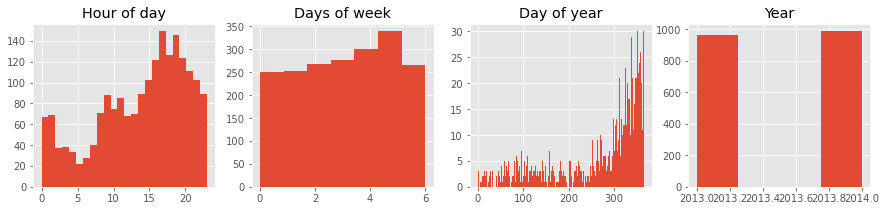

In [11]:
fig, ax = plt.subplots(1, 4, figsize = (15,3))
train_not_2016 = train[train['year'] < 2015]
ax[0].hist(train_not_2016['hour_of_day'], bins = 24)
ax[0].set_title('Hour of day')
ax[1].hist(train_not_2016['day_of_week'], bins = 7)
ax[1].set_title('Days of week')
ax[2].hist(train_not_2016['day_of_year'], bins = 365)
ax[2].set_title('Day of year')
ax[3].hist(train_not_2016['year'], bins = 4)
ax[3].set_title('Year');

* Podemos ver que durate a madruga o movimento é menor que durante o horario comercial.
* Aos dias da semana vemos que sabado e domingo tem uma redução.
* Nos dias do ano, verificamos que um aumento do consumo no final do ano.
* E que não existe muita diferença de um ano para o outro

Vou remover o ano de 2016 para melhorar a base de dados

In [12]:
train = train.drop(train.loc[(train['year'] == 2015)].index)
train = train.drop(train.loc[(train['year'] == 2016)].index)


In [13]:
train.shape

(1951, 11)

#### Relações entre pickup_datetime e a quantidade de corridas

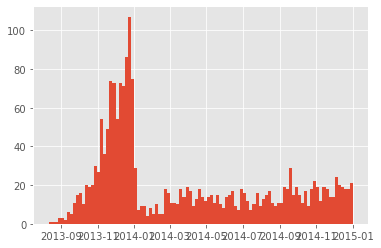

In [14]:
plt.hist(train['pickup_datetime'], bins = 100);

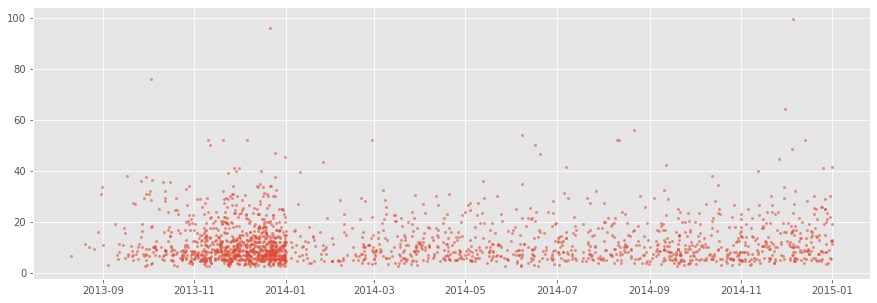

In [15]:
plt.figure(figsize = (15, 5))
plt.scatter(train['pickup_datetime'], train['fare_amount'], s = 5, alpha = 0.6)

Podemos verificar que existe uma linha entre os valores de 40 e 60 da tarifa. Isso pode ser alguma tarifa fixa de saida ou ida para rodoviarias ou aeroportos. Podemos verificar se isso se confirma.

Para isso, podemos verificar com um 'zoom' o intervalo entre esses valores e analisar

In [16]:
from collections import Counter
fare_zoom = train['fare_amount'][(train['fare_amount'] > 40) & (train['fare_amount'] < 60)]

In [17]:
fare_zoom.shape

(23,)

Temos 103 valores dentro desse intervalo, podemos continuar para fazer a contagem de cada valor.

In [18]:
common_fares_zoom = Counter(fare_zoom)

In [19]:
common_fares_zoom

Counter({41.5: 2,
         52.0: 7,
         46.5: 1,
         44.5: 1,
         48.5: 1,
         50.0: 2,
         42.5: 1,
         56.0: 1,
         54.0: 1,
         43.5: 1,
         41.0: 3,
         45.5: 1,
         47.0: 1})

In [20]:
most_common_fares_zoom = common_fares_zoom.most_common()

In [21]:
most_common_fares_zoom

[(52.0, 7),
 (41.0, 3),
 (41.5, 2),
 (50.0, 2),
 (46.5, 1),
 (44.5, 1),
 (48.5, 1),
 (42.5, 1),
 (56.0, 1),
 (54.0, 1),
 (43.5, 1),
 (45.5, 1),
 (47.0, 1)]

Podemos verificar que temos uma grande quantidade de valores fixos de 52 e 45. Vamos plotar um grafico para verificar melhor.

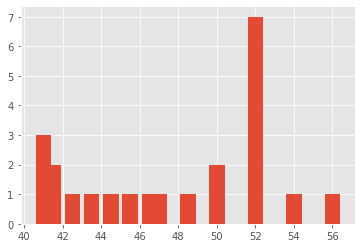

In [22]:
plt.bar([x[0] for x in most_common_fares_zoom], [x[1] for x in most_common_fares_zoom]);

In [23]:
import folium
from folium.plugins import HeatMap
# Definição da latitude e longitude de NYC

plt.figure(figsize= (10,20))

mpick = folium.Map(location = [40.65,-74.10], zoom_start=10)
mdrop = folium.Map(location = [40.65,-74.10], zoom_start=10)

<Figure size 720x1440 with 0 Axes>

Verificando o mapa de calor das saídas das corridas.

In [24]:
HeatMap(train[['pickup_latitude','pickup_longitude']].dropna(),radius=8,gradient={0.2:'blue',0.4:'purple',0.6:'orange',1.0:'red'}).add_to(mpick)
display(mpick)

Verificando o mapa de calor das chegadas das corridas.

In [25]:
HeatMap(train[['dropoff_latitude','dropoff_longitude']].dropna(),radius=8,gradient={0.2:'green',0.4:'yellow',0.6:'pink',1.0:'purple'}).add_to(mdrop)
display(mdrop)

Vamos buscar as coordenadas dos pontos do centro da cidade e no aeroporto, onde o volume é maior e também naquela média de valores visto anteriormente.
Vamos buscar primeiro a area do aerporto

In [26]:
coords = train[['dropoff_latitude',
                'dropoff_longitude']][(train['fare_amount'] > 40) &
                                       (train['fare_amount'] < 60) &
                                       (train['dropoff_latitude'] < 40.7) &
                                       (train['dropoff_latitude'] > 40.6) &
                                       (train['dropoff_longitude'] < -73.7) &
                                       (train['dropoff_longitude'] > -73.9)]

In [27]:
coords.shape

(9, 2)

In [28]:
coords.head()

,dropoff_latitude,dropoff_longitude
5305,40.643631,-73.783638
5468,40.648949,-73.783020
5491,40.644173,-73.782524
5588,40.673107,-73.833702
5719,40.645931,-73.776260


In [29]:
print(coords['dropoff_latitude'].median(), coords['dropoff_longitude'].median())

40.64512634277344 -73.7835922241211


Agora a área do centro da cidade.

In [30]:
coords = train[['dropoff_latitude',
                'dropoff_longitude']][(train['fare_amount'] > 40) &
                                       (train['fare_amount'] < 60) &
                                       (train['dropoff_latitude'] < 40.85) &
                                       (train['dropoff_latitude'] > 40.7) &
                                       (train['dropoff_longitude'] < -73.9) &
                                       (train['dropoff_longitude'] > -74.1)]

In [31]:
print(coords['dropoff_latitude'].median(), coords['dropoff_longitude'].median())

40.77145767211914 -73.944580078125


Agora vamos verificar os tres valores mais comuns que filtramos anteriormente e a localização

In [32]:
filtered = train[['fare_amount', 
                  'passenger_count']][((train['fare_amount'] == most_common_fares_zoom[0][0]) |
                                       (train['fare_amount'] == most_common_fares_zoom[1][0]) |
                                       (train['fare_amount'] == most_common_fares_zoom[2][0]))&
                                       (train['fare_amount'] < 60) &
                                       (train['dropoff_latitude'] < 40.7) & 
                                       (train['dropoff_latitude'] > 40.6) & 
                                       (train['dropoff_longitude'] < -73.7) &
                                       (train['dropoff_longitude'] > -73.9)]

In [33]:
filtered.shape

(4, 2)

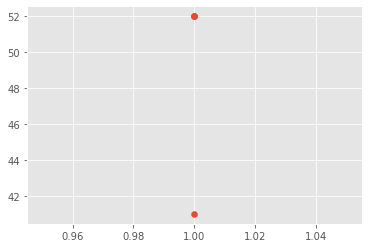

In [34]:
plt.scatter(filtered['passenger_count'], filtered['fare_amount'])

Podemos ver que o número de passageiros não interfere no valor da corrida. No caso, aparenta realmente ser uma tarifa fixa. Vamos analisar com as horas e os dias .

In [35]:
filtered = train[['fare_amount', 
                  'hour_of_day',
                  'day_of_week',
                  'day_of_year']][((train['fare_amount'] == most_common_fares_zoom[0][0]) |
                                       (train['fare_amount'] == most_common_fares_zoom[1][0]) |
                                       (train['fare_amount'] == most_common_fares_zoom[2][0]) |
                                       (train['fare_amount'] == most_common_fares_zoom[4][0]))&
                                       (train['fare_amount'] < 60) &
                                       (train['dropoff_latitude'] < 40.7) & 
                                       (train['dropoff_latitude'] > 40.6) & 
                                       (train['dropoff_longitude'] < -73.7) &
                                       (train['dropoff_longitude'] > -73.9)]

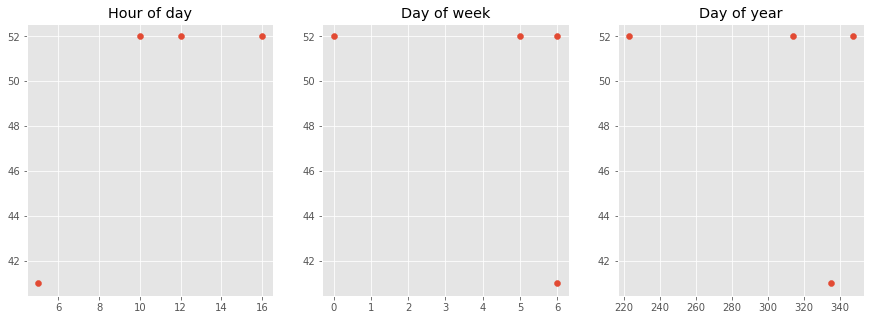

In [36]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].scatter(filtered['hour_of_day'], filtered['fare_amount'])
ax[0].set_title('Hour of day')
ax[1].scatter(filtered['day_of_week'], filtered['fare_amount'])
ax[1].set_title('Day of week')
ax[2].scatter(filtered['day_of_year'], filtered['fare_amount'])
ax[2].set_title('Day of year');

Podemos ver que, conforme o número de passageiros, essas outras variáveis também não interferem no valor da tarifa. Podemos com isso apagar nossa variaável pickup_datetime

In [37]:
train.drop('pickup_datetime', axis = 1, inplace = True)
train.head()

,dropoff_latitude,dropoff_longitude,fare_amount,passenger_count,pickup_latitude,pickup_longitude,hour_of_day,day_of_week,day_of_year,year
5003,40.742592,-73.953972,10.0,1,40.728981,-73.957542,9,1,329,2014
5004,40.841522,-73.939621,6.5,1,40.853523,-73.934090,9,1,273,2014
5005,40.842319,-73.939034,6.5,1,40.853634,-73.930634,19,4,178,2014
5006,40.680859,-73.971199,6.5,1,40.693134,-73.969048,23,2,295,2014
5007,40.873913,-73.898750,7.5,1,40.862232,-73.901405,15,3,261,2014


###  Distância


Agora podemos criar as novas variaveis de distancia, tanto euclidiana e manhathan, para isso precisamos fazer algumas adatapações.

In [38]:
lon1, lon2 = np.radians(train['pickup_longitude']), np.radians(train['dropoff_longitude'])
lat1, lat2 = np.radians(train['pickup_latitude']), np.radians(train['dropoff_latitude'])

Vamos subtrair as longitudes e latitudes

In [39]:
dlon = lon2 - lon1
dlat = lat2 - lat1

Agora com as variáveis já ajustadas, podemos aplicar e criar as novas distancias já em kilometros.

In [40]:
# Distância Euclidiana (Km)
a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
train['eucl_distance'] = 6373 * c

In [41]:
train.head()

,dropoff_latitude,dropoff_longitude,fare_amount,passenger_count,pickup_latitude,pickup_longitude,hour_of_day,day_of_week,day_of_year,year,eucl_distance
5003,40.742592,-73.953972,10.0,1,40.728981,-73.957542,9,1,329,2014,1.543551
5004,40.841522,-73.939621,6.5,1,40.853523,-73.934090,9,1,273,2014,1.413679
5005,40.842319,-73.939034,6.5,1,40.853634,-73.930634,19,4,178,2014,1.443378
5006,40.680859,-73.971199,6.5,1,40.693134,-73.969048,23,2,295,2014,1.377429
5007,40.873913,-73.898750,7.5,1,40.862232,-73.901405,15,3,261,2014,1.318286


In [42]:
# Distância Manhattan (Km)
a1 = np.sin(dlon / 2)**2
c1 = 2 * np.arctan2(np.sqrt(a1), np.sqrt(1 - a1))
a2 = np.sin(dlat / 2)**2
c2 = 2 * np.arctan2(np.sqrt(a2), np.sqrt(1 - a2))
train['manh_distance'] = 6373 * (c1 + c2)

In [43]:
train

,dropoff_latitude,dropoff_longitude,fare_amount,passenger_count,pickup_latitude,pickup_longitude,hour_of_day,day_of_week,day_of_year,year,eucl_distance,manh_distance
5003,40.742592,-73.953972,10.0,1,40.728981,-73.957542,9,1,329,2014,1.543551,1.911084
5004,40.841522,-73.939621,6.5,1,40.853523,-73.934090,9,1,273,2014,1.413679,1.950120
5005,40.842319,-73.939034,6.5,1,40.853634,-73.930634,19,4,178,2014,1.443378,2.192824
5006,40.680859,-73.971199,6.5,1,40.693134,-73.969048,23,2,295,2014,1.377429,1.604733
5007,40.873913,-73.898750,7.5,1,40.862232,-73.901405,15,3,261,2014,1.318286,1.594550
...,...,...,...,...,...,...,...,...,...,...,...,...
6995,40.728565,-73.860748,6.0,1,40.733994,-73.871117,15,1,302,2013,1.062216,1.757060
6996,40.789669,-73.954422,5.5,2,40.786087,-73.951340,9,2,254,2013,0.475524,0.741266
6997,40.763779,-73.976265,19.0,5,40.796963,-73.937904,9,4,270,2013,4.905388,7.957899
6998,40.693333,-73.830406,9.5,5,40.713631,-73.829918,13,3,311,2013,2.258119,2.312055


Text(0.5, 1.0, 'Manhattan Distance')

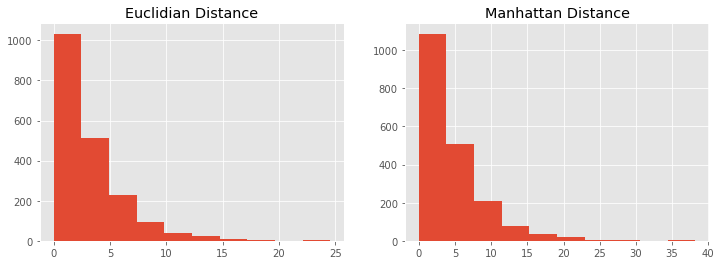

In [44]:
fig, ax = plt.subplots(1, 2, figsize = (12,4))
ax[0].hist(train['eucl_distance'])
ax[0].set_title('Euclidian Distance')
ax[1].hist(train['manh_distance'])
ax[1].set_title('Manhattan Distance')

Verificamos que as distancias são bem parecidas. Vamos manter para ver qual tem a maior importancia para o modelo ao final.
Com isso podemos iniciar o pré-processamento dos dados para iniciar a criação do nosso modelo.

In [47]:
train.shape

dropoff_latitude     0
dropoff_longitude    0
fare_amount          0
passenger_count      0
pickup_latitude      0
pickup_longitude     0
hour_of_day          0
day_of_week          0
day_of_year          0
year                 0
eucl_distance        0
manh_distance        0
dtype: int64

df_array = train.to_numpy()
df_array.shape

df_array[0]

import sqlite3

connection = sqlite3.connect('C:/Users/Paulo/NYC-Taxi/Code/Operationalization/nyctaxi/taxi.sqlite3')
cursor = connection.cursor()

criar_tabela = "CREATE TABLE IF NOT EXISTS taxi (\
                    dropoff_latitude	NUMERIC NOT NULL DEFAULT 0,\
                    dropoff_longitude	NUMERIC NOT NULL DEFAULT 0,\
                    fare_amount	NUMERIC NOT NULL DEFAULT 0,\
                    passenger_count	INTEGER NOT NULL DEFAULT 0,\
                    pickup_latitude	NUMERIC NOT NULL DEFAULT 0,\
                    pickup_longitude	INTEGER NOT NULL DEFAULT 0,\
                    hour_of_day	INTEGER NOT NULL DEFAULT 0,\
                    day_of_week	INTEGER NOT NULL DEFAULT 0,\
                    day_of_year	INTEGER NOT NULL DEFAULT 0,\
                    year	INTEGER NOT NULL DEFAULT 0,\
                    eucl_distance	NUMERIC NOT NULL DEFAULT 0,\
                    manh_distance	NUMERIC NOT NULL DEFAULT 0\
                    )"
cursor.execute(criar_tabela)


cursor.executemany("INSERT INTO taxi (dropoff_latitude, dropoff_longitude, fare_amount,passenger_count, pickup_latitude, \
                                        pickup_longitude, hour_of_day, day_of_week, day_of_year, year, \
                                        eucl_distance, manh_distance) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)", \
                                        df_array)
connection.commit()

# Exportanto Base de Dados

In [95]:
train.to_parquet(save_file)

In [96]:
train

,dropoff_latitude,dropoff_longitude,fare_amount,passenger_count,pickup_latitude,pickup_longitude,hour_of_day,day_of_week,day_of_year,year,eucl_distance,manh_distance
index,,,,,,,,,,,,
5003,40.742592,-73.953972,10.0,1,40.728981,-73.957542,9,1,329,2014,1.543551,1.911084
5004,40.841522,-73.939621,6.5,1,40.853523,-73.934090,9,1,273,2014,1.413679,1.950120
5005,40.842319,-73.939034,6.5,1,40.853634,-73.930634,19,4,178,2014,1.443378,2.192824
5006,40.680859,-73.971199,6.5,1,40.693134,-73.969048,23,2,295,2014,1.377429,1.604733
5007,40.873913,-73.898750,7.5,1,40.862232,-73.901405,15,3,261,2014,1.318286,1.594550
...,...,...,...,...,...,...,...,...,...,...,...,...
6995,40.728565,-73.860748,6.0,1,40.733994,-73.871117,15,1,302,2013,1.062216,1.757060
6996,40.789669,-73.954422,5.5,2,40.786087,-73.951340,9,2,254,2013,0.475524,0.741266
6997,40.763779,-73.976265,19.0,5,40.796963,-73.937904,9,4,270,2013,4.905388,7.957899
